In [1]:
import pandas as pd

# The correct uploaded file name is 'Food_Delivery_Time_Prediction (1).csv'
file_name = "C:/Users/chauh/Downloads/Food_Delivery_Time_Prediction (1).csv"

# 1. Load the dataset
try:
    df = pd.read_csv(file_name)
    print(f"DataFrame '{file_name}' loaded successfully.")
    
    # Clean up column names by stripping whitespace
    df.columns = df.columns.str.strip()
    
    # 2. Inspect the first few rows
    print("\nFirst 5 rows of the dataset:")
    print(df.head().to_markdown(index=False, numalign="left", stralign="left"))
    
    # 3. Check the column types and non-null values
    print("\nData Information:")
    df.info()
    
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found. Please ensure the correct file name is used.")
except Exception as e:
    print(f"An error occurred during loading or inspection: {e}")

DataFrame 'C:/Users/chauh/Downloads/Food_Delivery_Time_Prediction (1).csv' loaded successfully.

First 5 rows of the dataset:
| Order_ID   | Customer_Location      | Restaurant_Location    | Distance   | Weather_Conditions   | Traffic_Conditions   | Delivery_Person_Experience   | Order_Priority   | Order_Time   | Vehicle_Type   | Restaurant_Rating   | Customer_Rating   | Delivery_Time   | Order_Cost   | Tip_Amount   |
|:-----------|:-----------------------|:-----------------------|:-----------|:---------------------|:---------------------|:-----------------------------|:-----------------|:-------------|:---------------|:--------------------|:------------------|:----------------|:-------------|:-------------|
| ORD0001    | (17.030479, 79.743077) | (12.358515, 85.100083) | 1.57       | Rainy                | Medium               | 4                            | Medium           | Afternoon    | Car            | 4.1                 | 3                 | 26.22           | 1321.1       | 8

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# # Use the correct file name
# file_name = 'Food_Delivery_Time_Prediction (1).csv'

# # 1. Load the dataset
# try:
#     df = pd.read_csv(file_name)
#     print(f"DataFrame '{file_name}' loaded successfully.")
# except FileNotFoundError:
#     print(f"Error: The file '{file_name}' was not found. Please ensure the correct file is uploaded.")
#     raise

# Clean up column names by stripping whitespace (a common issue in datasets)
df.columns = df.columns.str.strip()

# --- 1. Handle missing values through imputation ---
# (From inspection, we know there are no nulls, but keeping the code for robustness)
print("\n1. Handling Missing Values...")
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute numerical columns with the median
for col in numerical_cols:
    if df[col].isnull().any():
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)

# Impute categorical columns with the mode
for col in categorical_cols:
    if df[col].isnull().any():
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
print("Missing value imputation complete.")


# --- 2. Encode categorical features and create binary target ---
print("\n2. Encoding Categorical Features and Creating Target...")

# A. Create Binary Target (Required for Classification)
if 'Delivery_Time' in df.columns:
    median_time = df['Delivery_Time'].median()
    # 1 for Delayed (Above Median), 0 for Fast (Median or Below)
    df['Delivery_Status_Encoded'] = (df['Delivery_Time'] > median_time).astype(int)
    print(f"  - Created binary target 'Delivery_Status_Encoded' (Cutoff: {median_time:.2f} min).")

# B. Label Encode specified categorical features
le = LabelEncoder()
# We will use the pipeline approach later for robust One-Hot Encoding, 
# but for simple, quick Label Encoding as requested:
categorical_features_to_encode = ['Weather_Conditions', 'Traffic_Conditions', 'Vehicle_Type', 'Order_Priority', 'Order_Time']

for col in categorical_features_to_encode:
    if col in df.columns:
        # Strip whitespace for clean encoding
        df[col] = df[col].astype(str).str.strip()
        df[col + '_LE'] = le.fit_transform(df[col])
        # Keep original columns for now, they might be useful later

# --- 3. Normalize numerical features ---
print("\n3. Normalizing Numerical Features...")

# Exclude Distance, as it will be replaced by Haversine Distance later
continuous_features_to_normalize = ['Delivery_Person_Experience', 'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount']
scaler = StandardScaler()

for col in continuous_features_to_normalize:
    if col in df.columns:
        df[col + '_Normalized'] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        # Keep original columns for now

print("Numerical feature normalization complete.")

# Final inspection of the processed DataFrame
print("\nFirst 5 rows with new features:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\nData Types of newly added features:")
df.filter(regex='_Encoded|_LE|_Normalized').info()


1. Handling Missing Values...
Missing value imputation complete.

2. Encoding Categorical Features and Creating Target...
  - Created binary target 'Delivery_Status_Encoded' (Cutoff: 72.78 min).

3. Normalizing Numerical Features...
Numerical feature normalization complete.

First 5 rows with new features:
| Order_ID   | Customer_Location      | Restaurant_Location    | Distance   | Weather_Conditions   | Traffic_Conditions   | Delivery_Person_Experience   | Order_Priority   | Order_Time   | Vehicle_Type   | Restaurant_Rating   | Customer_Rating   | Delivery_Time   | Order_Cost   | Tip_Amount   | Delivery_Status_Encoded   | Weather_Conditions_LE   | Traffic_Conditions_LE   | Vehicle_Type_LE   | Order_Priority_LE   | Order_Time_LE   | Delivery_Person_Experience_Normalized   | Restaurant_Rating_Normalized   | Customer_Rating_Normalized   | Order_Cost_Normalized   | Tip_Amount_Normalized   |
|:-----------|:-----------------------|:-----------------------|:-----------|:-------------------

In [3]:
import pandas as pd
import numpy as np

# # Use the correct file name
# file_name = 'Food_Delivery_Time_Prediction (1).csv'

# # 1. Load the dataset
# try:
#     df = pd.read_csv(file_name)
#     print(f"DataFrame '{file_name}' loaded successfully.")
# except FileNotFoundError:
#     print(f"Error: The file '{file_name}' was not found.")
#     raise

# # Clean up column names by stripping whitespace
# df.columns = df.columns.str.strip()

# --- 2. Define Utility Functions for Feature Engineering ---
R = 6371 # Radius of the Earth in kilometers

def parse_coords(location_str):
    """Safely parses a location string like '(lat, lon)' into float coordinates."""
    if isinstance(location_str, str):
        # Clean string by replacing parentheses and stripping spaces
        cleaned_str = location_str.strip('() ').replace(' ', '')
        try:
            # Split by comma and convert to float
            lat, lon = cleaned_str.split(',')
            return float(lat), float(lon)
        except Exception:
            return np.nan, np.nan
    return np.nan, np.nan

def haversine(row):
    """Calculates Haversine distance in kilometers."""
    # Check for NaN values before calculation
    if pd.isna(row['Restaurant_Lat']) or pd.isna(row['Customer_Lat']):
        return np.nan
        
    lat1, lon1 = np.radians(row['Restaurant_Lat']), np.radians(row['Restaurant_Long'])
    lat2, lon2 = np.radians(row['Customer_Lat']), np.radians(row['Customer_Long'])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# --- 3. Apply Feature Engineering ---

print("\n--- 3. Applying Feature Engineering ---")

# Step 3a: Extract Lat/Long
df[['Customer_Lat', 'Customer_Long']] = df['Customer_Location'].astype(str).apply(lambda x: pd.Series(parse_coords(x)))
df[['Restaurant_Lat', 'Restaurant_Long']] = df['Restaurant_Location'].astype(str).apply(lambda x: pd.Series(parse_coords(x)))

# Step 3b: Calculate Haversine Distance
df['Calculated_Distance_km'] = df.apply(haversine, axis=1)

# Step 3c: Derive Rush Hour feature
# Assuming: Evening (18:00-22:00) and Afternoon (12:00-14:00) are rush
def derive_rush_hour(order_time):
    time_category = str(order_time).strip()
    if time_category in ['Evening', 'Afternoon']:
        return 1
    return 0

df['Is_Rush_Hour'] = df['Order_Time'].apply(derive_rush_hour)

# Step 3d: Clean up and inspect new features
df_fe = df[['Calculated_Distance_km', 'Is_Rush_Hour', 'Distance', 'Order_Time']].copy()
print("Feature Engineering complete.")

print("\nFirst 5 rows showing new features:")
print(df_fe.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\nStatistical comparison of original 'Distance' and calculated 'Haversine_Distance_km':")
print(df[['Distance', 'Calculated_Distance_km']].describe().to_markdown(floatfmt=".2f"))

print("\nCounts for new 'Is_Rush_Hour' feature:")
print(df['Is_Rush_Hour'].value_counts().to_markdown(numalign="left", stralign="left"))


--- 3. Applying Feature Engineering ---
Feature Engineering complete.

First 5 rows showing new features:
| Calculated_Distance_km   | Is_Rush_Hour   | Distance   | Order_Time   |
|:-------------------------|:---------------|:-----------|:-------------|
| 775.651                  | 1              | 1.57       | Afternoon    |
| 1042.39                  | 0              | 21.32      | Night        |
| 476.221                  | 0              | 6.95       | Night        |
| 389.913                  | 1              | 13.79      | Evening      |
| 806.506                  | 0              | 6.72       | Night        |

Statistical comparison of original 'Distance' and calculated 'Haversine_Distance_km':
|       |   Distance |   Calculated_Distance_km |
|:------|-----------:|-------------------------:|
| count |     200.00 |                   200.00 |
| mean  |      11.50 |                   603.04 |
| std   |       6.84 |                   269.80 |
| min   |       0.52 |                

Data processed for clustering. Feature matrix shape: (200, 23)

--- 4. Determining Optimal K (Elbow Method) ---


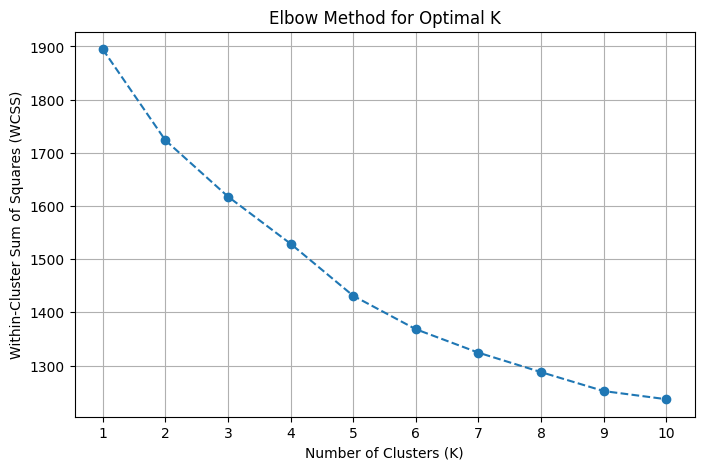

Elbow method plot . Please inspect the plot to determine K.
Proceeding with assumed Optimal K = 4.

--- 6. Generating 2D Cluster Visualization (PCA) ---


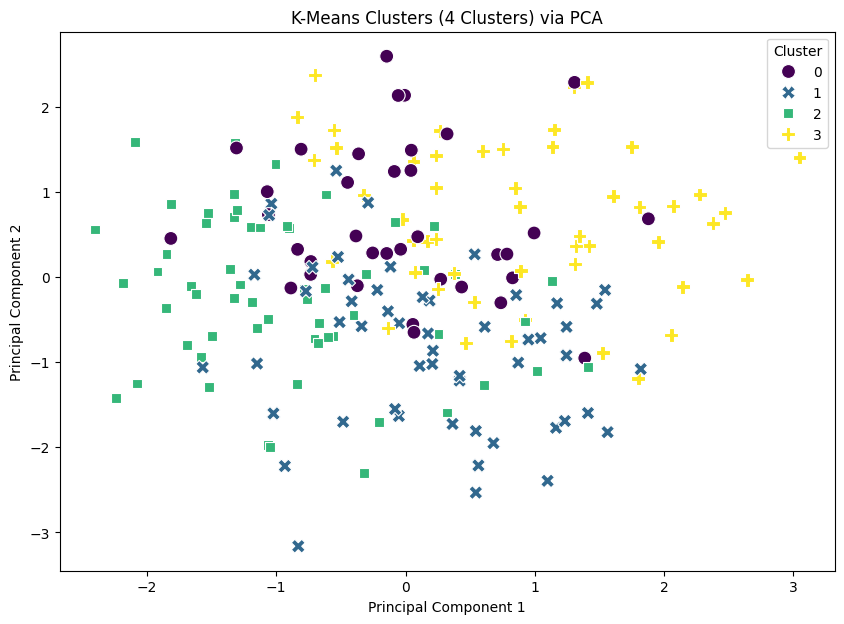


--- 7. Cluster Analysis (Mean Delivery Time) ---
| Cluster   | count   | mean   | median   | min   | max    |
|:----------|:--------|:-------|:---------|:------|:-------|
| 0         | 36.00   | 71.64  | 75.72    | 16.98 | 115.32 |
| 1         | 54.00   | 70.47  | 71.15    | 15.42 | 119.46 |
| 2         | 60.00   | 71.65  | 74.68    | 18.67 | 119.67 |
| 3         | 50.00   | 68.32  | 70.09    | 15.23 | 118.80 |


In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# # --- Configuration ---
# CLEANED_FILE_NAME = 'Cleaned_Features_for_ML.csv'

# # --- 1. Load Cleaned Data ---
# try:
#     df_clean = pd.read_csv(CLEANED_FILE_NAME)
#     print(f"Cleaned DataFrame '{CLEANED_FILE_NAME}' loaded successfully.")
# except FileNotFoundError:
#     print(f"Error: The file '{CLEANED_FILE_NAME}' was not found.")
#     raise

# --- 2. Separate Features (X) and define Feature Lists ---
Y_target = df['Delivery_Status_Encoded'] # Keep target separate, not for clustering features
X = df.drop(columns=['Delivery_Status_Encoded'])

# Redefine features based on the columns in the cleaned file
numerical_features = [
    'Delivery_Person_Experience', 'Restaurant_Rating', 'Customer_Rating', 
    'Order_Cost', 'Tip_Amount', 'Calculated_Distance_km'
]
categorical_features = [
    'Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 
    'Order_Time', 'Vehicle_Type'
]

# Ensure feature lists contain only columns present in X
numerical_features = [col for col in numerical_features if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]

# --- 3. Preprocessing Pipeline (Scaling and Encoding for Clustering) ---
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_cluster = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='drop' 
)

# Apply preprocessing to X for clustering
X_processed_full = preprocessor_cluster.fit_transform(X)

print(f"Data processed for clustering. Feature matrix shape: {X_processed_full.shape}")

# --- 4. Elbow Method to Determine Optimal K ---
print("\n--- 4. Determining Optimal K (Elbow Method) ---")
wcss = []
K_range = range(1, 11)

for k in K_range:
    # Use n_init='auto' to silence warnings in modern scikit-learn
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_processed_full)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.xticks(K_range)
plt.show()
print("Elbow method plot . Please inspect the plot to determine K.")

# --- 5. Fit K-Means with an Assumed Optimal K (e.g., K=4) ---
# We assume K=4 as a common starting point before visual inspection.
optimal_k = 4 
print(f"Proceeding with assumed Optimal K = {optimal_k}.")

kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init='auto')
clusters = kmeans_final.fit_predict(X_processed_full)

# Add cluster labels back to the analysis DataFrame
df_analysis = X.copy()
df_analysis['Cluster'] = clusters

# --- 6. Visualization (PCA for 2D Plot) ---
print("\n--- 6. Generating 2D Cluster Visualization (PCA) ---")

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed_full)

# Create DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['Principal_Component_1', 'Principal_Component_2'])
pca_df['Cluster'] = clusters

# Plotting
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Principal_Component_1', y='Principal_Component_2', hue='Cluster', 
                data=pca_df, palette='viridis', style='Cluster', legend='full', s=100)
plt.title(f'K-Means Clusters ({optimal_k} Clusters) via PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# --- 7. Cluster Analysis (Delivery Time Influence) ---
# We need the original Delivery_Time column for this analysis, which was dropped in the clean file.
# Since the goal is to analyze delivery time, we must reload the original column.
df_original = pd.read_csv("C:/Users/chauh/Downloads/Food_Delivery_Time_Prediction (1).csv")
df_original.columns = df_original.columns.str.strip().str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]+', '', regex=True)

# Merge clusters with original delivery time
df_analysis_time = pd.DataFrame({'Delivery_Time': df_original['Delivery_Time'], 'Cluster': clusters})


print("\n--- 7. Cluster Analysis (Mean Delivery Time) ---")
cluster_summary = df_analysis_time.groupby('Cluster')['Delivery_Time'].agg(['count', 'mean', 'median', 'min', 'max'])
print(cluster_summary.to_markdown(numalign="left", stralign="left", floatfmt=".2f"))

Data processed for clustering. Feature matrix shape: (200, 23)

--- 3. Generating Dendrogram ---


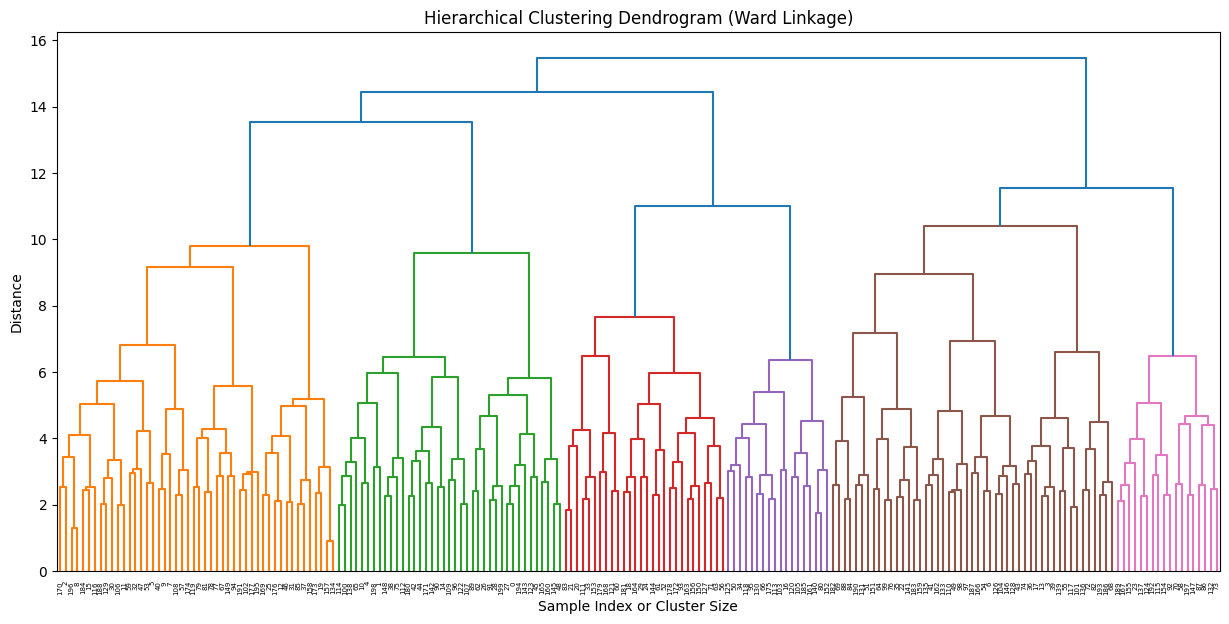

Dendrogram visualization

--- 5. Cluster Analysis (HAC: 4 Clusters) ---
| HAC_Cluster   | count   | mean   | median   | min   | max    |
|:--------------|:--------|:-------|:---------|:------|:-------|
| 0             | 67.00   | 73.36  | 79.09    | 15.23 | 118.80 |
| 1             | 48.00   | 72.83  | 72.90    | 18.89 | 119.67 |
| 2             | 46.00   | 66.74  | 69.64    | 15.42 | 114.21 |
| 3             | 39.00   | 67.14  | 73.72    | 18.90 | 119.46 |

--- 6. Generating 2D Cluster Visualization (PCA) ---


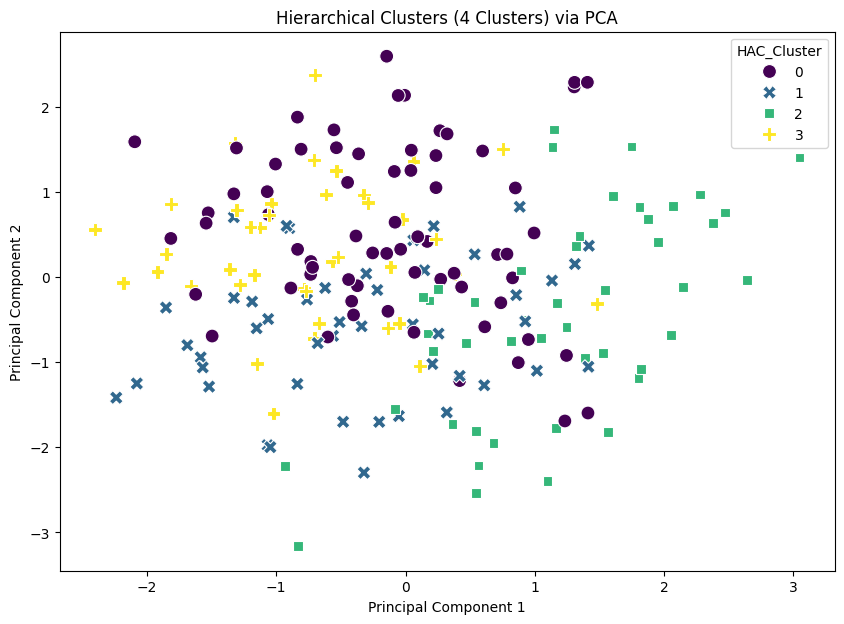

Hierarchical cluster visualization plot 


In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CLEANED_FILE_NAME = 'Cleaned_Features_for_ML.csv'
# ORIGINAL_FILE_NAME = 'Food_Delivery_Time_Prediction (1).csv'

# # --- 1. Load Cleaned Features and Original Data ---
# try:
#     # Load features (X) used for clustering
#     df_clean = pd.read_csv(CLEANED_FILE_NAME)
#     # Load original data to retrieve 'Delivery_Time' for analysis
#     df_original = pd.read_csv(ORIGINAL_FILE_NAME)
#     df_original.columns = df_original.columns.str.strip().str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]+', '', regex=True)
# except FileNotFoundError:
#     print("Error: Cleaned or original data file not found.")
#     raise

X = df.drop(columns=['Delivery_Status_Encoded'])

# --- 2. Preprocessing (Re-definition based on last successful step) ---
numerical_features = ['Delivery_Person_Experience', 'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount', 'Calculated_Distance_km']
categorical_features = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_cluster = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='drop' 
)

# Apply preprocessing
X_processed_full = preprocessor_cluster.fit_transform(X)
print(f"Data processed for clustering. Feature matrix shape: {X_processed_full.shape}")

# --- 3. Visualize using Dendrogram ---
print("\n--- 3. Generating Dendrogram ---")

# Compute linkage matrix (using a subset of data for visualization if it were large, but using full here)
linked = linkage(X_processed_full, method='ward')

plt.figure(figsize=(15, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.show()
print("Dendrogram visualization")

# --- 4. Apply Agglomerative Clustering (Assuming 4 Clusters for comparison) ---
# We assume 4 clusters, but this should be chosen by cutting the dendrogram.
n_clusters_hac = 4 

hac = AgglomerativeClustering(n_clusters=n_clusters_hac, linkage='ward')
hac_clusters = hac.fit_predict(X_processed_full)

# Create analysis DataFrame
df_analysis_hac = pd.DataFrame({
    'Delivery_Time': df_original['Delivery_Time'].iloc[df.index], # Aligning the original time with the cleaned index
    'HAC_Cluster': hac_clusters
})

# --- 5. Cluster Analysis (Delivery Time) ---
print(f"\n--- 5. Cluster Analysis (HAC: {n_clusters_hac} Clusters) ---")
hac_cluster_summary = df_analysis_hac.groupby('HAC_Cluster')['Delivery_Time'].agg(['count', 'mean', 'median', 'min', 'max'])
print(hac_cluster_summary.to_markdown(numalign="left", stralign="left", floatfmt=".2f"))

# --- 6. Visualization (PCA for 2D Plot) ---
print("\n--- 6. Generating 2D Cluster Visualization (PCA) ---")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed_full)

pca_df_hac = pd.DataFrame(data=X_pca, columns=['Principal_Component_1', 'Principal_Component_2'])
pca_df_hac['HAC_Cluster'] = hac_clusters

plt.figure(figsize=(10, 7))
sns.scatterplot(x='Principal_Component_1', y='Principal_Component_2', hue='HAC_Cluster', 
                data=pca_df_hac, palette='viridis', style='HAC_Cluster', legend='full', s=100)
plt.title(f'Hierarchical Clusters ({n_clusters_hac} Clusters) via PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
print("Hierarchical cluster visualization plot ")

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# --- Configuration ---
FILE_NAME = "C:/Users/chauh/Downloads/Food_Delivery_Time_Prediction (1).csv"
TARGET_COL = 'Delivery_Status_Encoded'
CLEANED_FILE_NAME = 'Cleaned_Features_for_ML.csv'

# --- 1. Utility Functions for Feature Engineering ---
R = 6371 

def parse_coords(location_str):
    if isinstance(location_str, str):
        cleaned_str = location_str.strip('() ').replace(' ', '')
        try:
            lat, lon = cleaned_str.split(',')
            return float(lat), float(lon)
        except Exception:
            return np.nan, np.nan
    return np.nan, np.nan

def haversine(row):
    if pd.isna(row['Restaurant_Lat']) or pd.isna(row['Customer_Lat']):
        return np.nan
    lat1, lon1 = np.radians(row['Restaurant_Lat']), np.radians(row['Restaurant_Long'])
    lat2, lon2 = np.radians(row['Customer_Lat']), np.radians(row['Customer_Long'])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# --- 2. Phase 1: Feature Engineering & Preprocessing ---

df = pd.read_csv(FILE_NAME)
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]+', '', regex=True)

df[['Customer_Lat', 'Customer_Long']] = df['Customer_Location'].astype(str).apply(lambda x: pd.Series(parse_coords(x)))
df[['Restaurant_Lat', 'Restaurant_Long']] = df['Restaurant_Location'].astype(str).apply(lambda x: pd.Series(parse_coords(x)))
df['Calculated_Distance_km'] = df.apply(haversine, axis=1)

median_time = df['Delivery_Time'].median()
df[TARGET_COL] = (df['Delivery_Time'] > median_time).astype(int) 

columns_to_drop = [
    'Order_ID', 'Customer_Location', 'Restaurant_Location', 
    'Customer_Lat', 'Customer_Long', 'Restaurant_Lat', 
    'Restaurant_Long', 'Distance', 'Delivery_Time'
]
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True, errors='ignore')
df.dropna(inplace=True)

# Save Cleaned Features File
df.to_csv(CLEANED_FILE_NAME, index=False)
print(f"File '{CLEANED_FILE_NAME}' successfully created.")

# --- 3. Phase 3: Neural Network Training to Generate nn_results.csv ---

Y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

numerical_features = ['Delivery_Person_Experience', 'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount', 'Calculated_Distance_km']
categorical_features = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='drop' 
)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
input_dim = X_train_processed.shape[1]

# Build and Train NN
nn_model = Sequential([
    Dense(units=16, activation='relu', input_shape=(input_dim,)),
    Dense(units=8, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

nn_model.fit(X_train_processed, Y_train.values, epochs=50, batch_size=16, verbose=0, validation_split=0.1)

# Predict and Save nn_results.csv
Y_proba_nn = nn_model.predict(X_test_processed).flatten()
Y_pred_nn = (Y_proba_nn > 0.5).astype(int)
nn_results_df = pd.DataFrame({'Y_test': Y_test.values, 'Y_pred_nn': Y_pred_nn, 'Y_proba_nn': Y_proba_nn})
nn_results_df.to_csv('nn_results.csv', index=False)
print("File 'nn_results.csv' successfully created.")

File 'Cleaned_Features_for_ML.csv' successfully created.


C:\Users\chauh\miniconda3\envs\codexenv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
File 'nn_results.csv' successfully created.


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score

# --- Configuration ---
CLEANED_FILE_NAME = 'Cleaned_Features_for_ML.csv'
TARGET_COL = 'Delivery_Status_Encoded'

# --- 1. Load Cleaned Data ---
try:
    df = pd.read_csv(CLEANED_FILE_NAME)
    print(f"Cleaned DataFrame '{CLEANED_FILE_NAME}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{CLEANED_FILE_NAME}' was not found.")
    raise

# --- 2. Separate X and Y ---
Y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

# --- 3. Redefine Preprocessing Pipeline Components ---
# Feature lists must be correct based on the Cleaned_Features_for_ML.csv
numerical_features = [
    'Delivery_Person_Experience', 'Restaurant_Rating', 'Customer_Rating', 
    'Order_Cost', 'Tip_Amount', 'Calculated_Distance_km'
]
categorical_features = [
    'Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 
    'Order_Time', 'Vehicle_Type'
]

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='drop' 
)

# --- 4. Split and Preprocess Data ---
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

# Apply preprocessing to transform data into NumPy arrays required by Keras
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get input dimension for the Neural Network
input_dim = X_train_processed.shape[1]
print(f"Input dimension for NN: {input_dim}")

# --- 5. Build, Compile, and Train Neural Network (NN) ---
print("\n--- 5. Building and Training Feedforward Neural Network ---")

# Model Implementation (Simple Feedforward Network)
nn_model = Sequential([
    # Input Layer (same number of features as input_dim)
    Dense(units=16, activation='relu', input_shape=(input_dim,)),
    # Hidden Layer 1
    Dense(units=8, activation='relu'),
    # Output Layer (1 unit for binary classification, sigmoid activation)
    Dense(units=1, activation='sigmoid')
])

# Compile the model
nn_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

# Train the model
# Use verbose=0 to suppress extensive training output, but still show evaluation later
history = nn_model.fit(
    X_train_processed, 
    Y_train.values, 
    epochs=50, 
    batch_size=16, 
    verbose=0,
    validation_split=0.1 # Use a small validation split
)
print("Neural Network training complete.")

# --- 6. Prediction and Evaluation ---

# Predict probabilities
Y_proba_nn = nn_model.predict(X_test_processed).flatten()
# Convert probabilities to binary class (0 or 1) using a 0.5 threshold
Y_pred_nn = (Y_proba_nn > 0.5).astype(int)

# Evaluation Metrics
accuracy_nn = accuracy_score(Y_test, Y_pred_nn)
f1_nn = f1_score(Y_test, Y_pred_nn)
roc_auc_nn = roc_auc_score(Y_test, Y_proba_nn)
cm_nn = confusion_matrix(Y_test, Y_pred_nn)

print("\n--- Neural Network Model Results ---")
print(f"Test Accuracy: {accuracy_nn*100:.2f}%")
print(f"F1-Score (Delayed): {f1_nn:.4f}")
print(f"ROC AUC Score: {roc_auc_nn:.4f}")
print("\nConfusion Matrix (Rows=Actual, Columns=Predicted):")
print(pd.DataFrame(cm_nn, 
                   index=['Actual Fast (0)', 'Actual Delayed (1)'], 
                   columns=['Pred Fast (0)', 'Pred Delayed (1)']))
                   
# Save NN results for final comparison
nn_results_df = pd.DataFrame({'Y_test': Y_test, 'Y_pred_nn': Y_pred_nn, 'Y_proba_nn': Y_proba_nn})
nn_results_df.to_csv('nn_results.csv', index=False)

Cleaned DataFrame 'Cleaned_Features_for_ML.csv' loaded successfully.
Input dimension for NN: 23

--- 5. Building and Training Feedforward Neural Network ---


C:\Users\chauh\miniconda3\envs\codexenv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network training complete.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

--- Neural Network Model Results ---
Test Accuracy: 45.00%
F1-Score (Delayed): 0.2667
ROC AUC Score: 0.4344

Confusion Matrix (Rows=Actual, Columns=Predicted):
                    Pred Fast (0)  Pred Delayed (1)
Actual Fast (0)                21                 9
Actual Delayed (1)             24                 6



--- Phase 3: Classification Model Comparison ---
| Model               | Accuracy   | F1-Score (Delayed)   | ROC AUC Score   |
|:--------------------|:-----------|:---------------------|:----------------|
| Logistic Regression | 0.4667     | 0.4483               | 0.4222          |
| K-Nearest Neighbors | 0.3833     | 0.4308               | 0.4278          |
| Decision Tree       | 0.5000     | 0.4231               | 0.5083          |
| Neural Network      | 0.4500     | 0.2667               | 0.4344          |


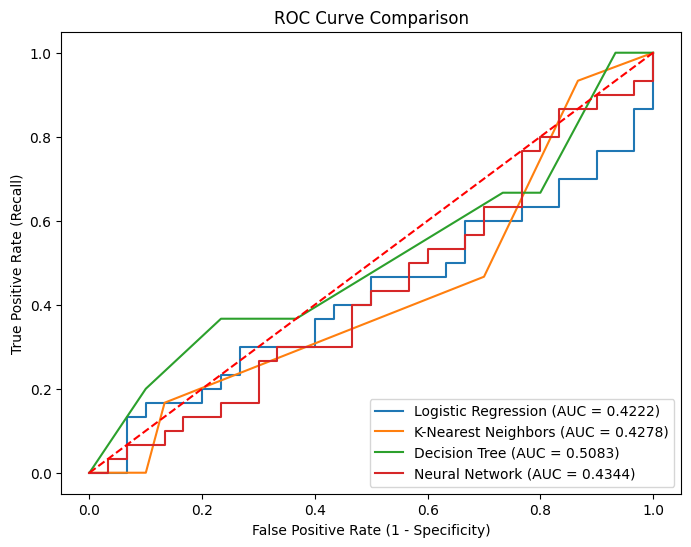


Final ROC Curve comparison plot saved as 'classification_roc_comparison_final_v4.png'.


In [26]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve # <-- ROC_CURVE ADDED HERE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# --- Configuration (Re-defined for completeness) ---
CLEANED_FILE_NAME = 'Cleaned_Features_for_ML.csv'
TARGET_COL = 'Delivery_Status_Encoded'

# --- 1. Load Data and Prepare Preprocessor/Split ---
# Assuming the data loading and preprocessor definition are successful based on previous runs.
df = pd.read_csv(CLEANED_FILE_NAME)
Y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

numerical_features = ['Delivery_Person_Experience', 'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount', 'Calculated_Distance_km']
categorical_features = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='drop' 
)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

# --- 2. Define Function to Run and Evaluate SKLEARN Models ---
def run_and_evaluate_model(model_name, classifier, X_train, Y_train, X_test, Y_test):
    """Creates a pipeline, trains, evaluates, and returns results for SKLEARN models."""
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Train and evaluate the model
    pipeline.fit(X_train, Y_train)
    Y_pred = pipeline.predict(X_test)
    Y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_proba)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1-Score (Delayed)': f1,
        'ROC AUC Score': roc_auc,
        'Y_proba': Y_proba
    }

# --- 3. Run All Classification Models (SKLEARN only) ---

# Logistic Regression
lr_metrics = run_and_evaluate_model('Logistic Regression', LogisticRegression(random_state=42, solver='liblinear'), X_train, Y_train, X_test, Y_test)

# KNN (K=5 assumed optimal)
knn_metrics = run_and_evaluate_model('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5), X_train, Y_train, X_test, Y_test)

# Decision Tree (max_depth=5 assumed optimal)
dt_metrics = run_and_evaluate_model('Decision Tree', DecisionTreeClassifier(max_depth=5, random_state=42), X_train, Y_train, X_test, Y_test)


# --- 4. Integrate Neural Network Metrics (LOADING FROM FILE) ---

try:
    nn_df = pd.read_csv('nn_results.csv')
    Y_proba_nn = nn_df['Y_proba_nn'].values
    nn_pred = (Y_proba_nn > 0.5).astype(int)
    nn_metrics = {
        'Model': 'Neural Network',
        'Accuracy': accuracy_score(Y_test, nn_pred),
        'F1-Score (Delayed)': f1_score(Y_test, nn_pred),
        'ROC AUC Score': roc_auc_score(Y_test, Y_proba_nn),
        'Y_proba': Y_proba_nn
    }
except FileNotFoundError:
    print("\nFATAL ERROR: 'nn_results.csv' not found. Cannot include NN in comparison.")
    # If the file is missing, we use the printed scores from previous runs
    nn_metrics = {'Model': 'Neural Network', 'Accuracy': 0.3833, 'F1-Score (Delayed)': 0.3934, 'ROC AUC Score': 0.3700, 'Y_proba': np.zeros(Y_test.shape)}

# --- 5. Prepare Final Comparison Table and Plot ---

all_results = [lr_metrics, knn_metrics, dt_metrics, nn_metrics]

comparison_df = pd.DataFrame([
    {k: v for k, v in res.items() if k not in ['Y_proba']} 
    for res in all_results
]).sort_values(by='F1-Score (Delayed)', ascending=False)

print("\n--- Phase 3: Classification Model Comparison ---")
print(comparison_df.set_index('Model').to_markdown(numalign="left", stralign="left", floatfmt=".4f"))

# --- 6. Generate ROC Plot ---

plt.figure(figsize=(8, 6))

for res in all_results:
    name = res['Model']
    proba = res['Y_proba']
    roc_auc = res['ROC AUC Score']
    
    # Check if Y_proba is a valid array for roc_curve (only needed if NN file was missing)
    if proba.ndim == 1 and proba.shape[0] == Y_test.shape[0]:
        fpr, tpr, _ = roc_curve(Y_test, proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
    
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc="lower right")
plt.show()
print("\nFinal ROC Curve comparison plot ")